# Fields of Study and Earnings Inequality with Highlight on a Gender-Specific Perpective

 * _Read the Data and Manipulation_
 * _Explore the Data: Summary Statistics_
 * _OLS Regression Models_
 * _Visualize the Results_

Does a college degree equally benefit every graduate in terms of earnings? Many individuals invest thousands of dollars each year to pursue a bachelor’s degree; however, a college degree does not always guarantee a decent salary for all graduates despite the steep cost of tuition. The labour market outcomes are ideal for some people while much worse for others. Although this disparity can be affected by factors such as innate abilities and family backgrounds, fields of study, as the most intuitive horizontal stratification for college students, may play an essential role in determining earnings inequality among college graduates.

To explore the impact of fields of study on the earnings gap, this analysis will utilize the US National Survey of College Graduates (NSCG) in 2019 and perform OLS regression to draw inferences on the magnitude of impact on annual salary by fields of study of bachelor’s degree. The NSCG public use microdata contains demographic and family background information (e.g., parent's education level), which are appropriate to include in the model as control variables. First, I picture the overall effect of fields of study on annual salary under different sets of covariates; second, I compare the impact on earnings across fields of study within gender and investigate the interaction effects of gender and fields of study on earnings. 

The findings reveal that certain traditional STEM majors, such as engineering and computer science, tend to remarkably boost earnings in comparison to other STEM majors, such as biology. Non-STEM fields, except for management, are likely to yield adverse effects. A degree in education demonstrates the most significant negative impact on earnings regardless of gender. Furthermore, females benefit more from a degree in engineering, and there is almost no gender pay gap on average for engineering degree holders. In contrast, females with degrees in female-dominated fields like education and health are relatively disadvantaged in earnings.

In [6]:
knitr::opts_chunk$set(echo = TRUE)
knitr::opts_chunk$set(message = FALSE) 
knitr::opts_chunk$set(warning = FALSE) 

In [7]:
library(tidyverse)
library(readr)
library(survey)
library(srvyr)
library(convey)
library(dplyr)
library(tidyr)
library(plm)
library(ineq)
library(ggplot2)
library(scales)
library(car)
library(gtsummary)
library(sjPlot)
library(sjmisc)
library(sjlabelled)
library(stargazer)
library(knitr)
library(kableExtra)

## Read the Data and Manipulation

  Data are from the 2019 National Survey of College Graduates (NSCG), sponsored by the National Science Foundation (NSF). The target population of NSCG is individuals younger than 76, living in the United States during the survey reference week, and who obtained a bachelor’s degree or higher before 1 January 2018. 

In [ ]:
raw <- read_sas('epcg19.sas7bdat') 

raw_select <- select(raw, REFYR, AGE, GENDER, MINRTY, ASIAN, BLACK,  WHITE, HISPANIC, RACETHM, 
               HCAPIN, MARIND, BSDGN, BTHST, BTHUS, COHORT,CTZN, CTZUSIN, 
               BAACYR, BAAYR3, BAPBPR, BAIND, BADGRUS,  D2DG, DGRDG, DGRYR, HDACY3,
               HDACYR, N2BAMED,  NBAMEBG, NBAMEMG, NBAMENG, 
               EARN, HRSWK, LFSTAT, SALARY, WKSWK, WKSYR, 
               EDDAD, EDMOM,
               EMSECSM, EMTP, EMUS,
               MGRNAT, MGROTH, MGRSOC,
               RESPLO3, RESPLOC, WTSURVY)

The NSCG has advantages, particularly in studying earnings inequality among college graduates compared to other data sources. First, the NSCG contains not only vertical stratification (e.g., degree types) but also horizontal stratification, such as fields of study, at a relatively detailed level. Furthermore, the NSCG provides information on work activities and salaries of individuals, which is crucial to associate fields of study with earnings. Finally, the NSCG includes rich demographic and family background dimensions, such as age, race, citizenship status, and parents’ education level. Although these variables are not our primary interests, they are necessary covariates given their potential effects on individual earnings.

I recoded some columns for easier interpretation.

In [ ]:
data_recode <- raw_select %>%
  mutate(
    RACETHM = case_when(
      RACETHM =="1"	~ "1: Asian, non-Hispanic ONLY",
      RACETHM =="2"	~ "2: American Indian/Alaska Native, non-Hispanic ONLY",
      RACETHM =="3"	~ "3: Black, non-Hispanic ONLY",
      RACETHM =="4"	~ "4: Hispanic, any race",
      RACETHM =="5"	~ "5: White, non-Hispanic ONLY",
      RACETHM =="6"	~ "6: Non-Hispanic Native Hawaiian/Other Pacific Islander ONLY",
      RACETHM =="7"	~ "7: Multiple Race, non-Hispanic",
      TRUE ~ "NA"),
    COHORT = case_when(
      COHORT =="E"	~ "E: NSCG - 2011 ACS",
      COHORT =="F"	~ "F: NSCG - 2013 ACS",
      COHORT =="G"	~ "G: NSCG - 2015 ACS",
      COHORT =="H"	~ "H: NSCG - 2017 ACS",
      TRUE ~ "NA"),
    BAPBPR = case_when(
      BAPBPR =="1"~ "1: Publicly controlled",
      BAPBPR =="2"	~ "2: Privately controlled",
      BAPBPR =="L"	~ "L: Logical Skip",
      BAPBPR =="M"	~ "M: Public/Private status information is not available",
      TRUE ~ "NA"),
    DGRDG = case_when(
      DGRDG =="0"	~ "0: No specific degree",
      DGRDG =="1"	~ "1: Bachelor''s",
      DGRDG =="2"	~ "2: Master''s",
      DGRDG =="3"	~ "3: Doctorate",
      DGRDG =="4"	~ "4: Professional",
      DGRDG =="5"	~ "5: Other",
      DGRDG =="L"	~ "L: Logical Skip",
      TRUE ~ "NA"),
    NBAMEBG = case_when(
      NBAMEBG =="1"	~ "1: S&E fields",
      NBAMEBG =="2"	~ "2: S&E related fields",
      NBAMEBG =="3"	~ "3: Non-S&E fields",
      NBAMEBG =="4"	~ "4: Logical skip",
      TRUE ~ "NA"),
    NBAMEMG = case_when(
      NBAMEMG =="1"	~ "1: Computer and mathematical sciences",
      NBAMEMG =="2"	~ "2: Biological, agricultural and environmental life sciences",
      NBAMEMG =="3"	~ "3: Physical and related sciences",
      NBAMEMG =="4"	~ "4: Social and related sciences",
      NBAMEMG =="5"	~ "5: Engineering",
      NBAMEMG =="6"	~ "6: S&E-Related Fields",
      NBAMEMG =="7"	~ "7: Non-S&E Fields",
      NBAMEMG =="8"	~ "8: Logical Skip",
      NBAMEMG =="9"	~ "9: Other categories",
      TRUE ~ "NA"),
    NBAMENG = case_when(
      NBAMENG == "11"	~ "11: Computer and information sciences",
      NBAMENG =="12"	~ "12: Mathematics and statistics",
      NBAMENG =="21"	~ "21: Agricultural and food sciences",
      NBAMENG =="22"	~ "22: Biological sciences",
      NBAMENG =="23"	~ "23: Environmental life sciences",
      NBAMENG =="31"	~ "31: Chemistry, except biochemistry",
      NBAMENG =="32"	~ "32: Earth, atmospheric and ocean sciences",
      NBAMENG =="33"	~ "33: Physics and astronomy",
      NBAMENG == "34"	~ "34: Other physical sciences",
      NBAMENG =="41"	~ "41: Economics",
      NBAMENG =="42"	~ "42: Political and related sciences",
      NBAMENG =="43"	~ "43: Psychology",
      NBAMENG =="44"	~ "44: Sociology and anthropology",
      NBAMENG =="45"	~ "45: Other social sciences",
      NBAMENG =="51"	~ "51: Aerospace, aeronautical and astronautical engineering",
      NBAMENG =="52"	~ "52: Chemical engineering",
      NBAMENG =="53"	~ "53: Civil and architectural engineering",
      NBAMENG =="54"	~ "54: Electrical and computer engineering",
      NBAMENG =="55"	~ "55: Industrial engineering",
      NBAMENG =="56"	~ "56: Mechanical engineering",
      NBAMENG =="57"	~ "57: Other engineering",
      NBAMENG =="61"	~ "61: Health",
      NBAMENG =="62"	~ "62: Science and mathematics teacher education",
      NBAMENG =="63"	~ "63: Technology and Technical Fields",
      NBAMENG =="64"	~ "64: Other S&E related fields",
      NBAMENG =="71"	~ "71: Management and administration fields",
      NBAMENG =="72"	~ "72: Education, except science and math teacher education",
      NBAMENG =="73"	~ "73: Social service and related fields",
      NBAMENG =="74"	~ "74: Sales and marketing fields",
      NBAMENG =="75"	~ "75: Art and Humanities Fields",
      NBAMENG =="76"	~ "76: Other Non-S&E fields",
      NBAMENG =="98"	~ "98: Logical Skip",
      NBAMENG =="99"	~ "99: Other categories",
      TRUE ~ "NA"),
    EDDAD = case_when(
      EDDAD =="1"	~ "1: Less than high school completed",
      EDDAD =="2"	~ "2: High school diploma or equivalent",
      EDDAD =="3"	~ "3: Some college, vocational, or trade school (including 2-year degrees)",
      EDDAD =="4"	~ "4: Bachelors degree (e.g. BS, BA, AB)",
      EDDAD =="5"	~ "5: Masters degree (e.g. MS, MA, MBA)",
      EDDAD =="6"	~ "6: Professional degree (e.g. JD, LLB, MD, DDS, etc.)",
      EDDAD =="7"	~ "7: Doctorate (e.g. PhD, DSc, EdD, etc.)",
      EDDAD =="8"	~ "8: Not applicable",
      TRUE ~ "NA"),
    EDMOM = case_when(
      EDMOM =="1"	~ "1: Less than high school completed",
      EDMOM =="2"	~ "2: High school diploma or equivalent",
      EDMOM =="3"	~ "3: Some college, vocational, or trade school (including 2-year degrees)",
      EDMOM =="4"	~ "4: Bachelors degree (e.g. BS, BA, AB)",
      EDMOM =="5"	~ "5: Masters degree (e.g. MS, MA, MBA)",
      EDMOM =="6"	~ "6: Professional degree (e.g. JD, LLB, MD, DDS, etc.)",
      EDMOM =="7"	~ "7: Doctorate (e.g. PhD, DSc, EdD, etc.)",
      EDMOM =="8"	~ "8: Not applicable",
      TRUE ~ "NA"),
    EMSECSM = case_when(
      EMSECSM == "1"	~ "1: Educational Institution",
      EMSECSM == "2"	~ "2: Government",
      EMSECSM == "3"	~ "3: Business/Industry",
      EMSECSM == "L"	~ "L: Logical Skip",
      TRUE ~ "NA"),
    EMTP = case_when(
      EMTP == "01"~ "01: Elementary, middle, or secondary school",
      EMTP =="02"	~ "02: 2-year college, junior college, or technical institute",
      EMTP =="03"	~ "03: 4-year college or university",
      EMTP =="04"	~ "04: Medical school",
      EMTP =="05"	~ "05: University research institute",
      EMTP =="06"	~ "06: Other (Educational Institution)",
      EMTP =="10"	~ "10: Private for-profit (non-educational institution)",
      EMTP =="11"	~ "11: Private non-profit (non-educational institution)",
      EMTP =="12"	~ "12: Self-employed, not incorporated (non-educational institution)",
      EMTP =="13"	~ "13: Self-employed, incorporated (non-educational institution)",
      EMTP =="14"	~ "14: Local government (non-educational institution)",
      EMTP =="15"	~ "15: State government (non-educational institution)",
      EMTP =="16"	~ "16: U.S. military (non-educational institution)",
      EMTP =="17"	~ "17: U.S. government (non-educational institution)",
      EMTP =="18"	~ "18: Other (non-educational institution)",
      EMTP =="L"	~ "L: Logical Skip",
      TRUE ~ "NA")
    )

In [ ]:
write.csv(data_recode, "first selection recode.csv") #save the subseted data

In [4]:
data <- read.csv('first selection recode.csv')

It is necessary to transfer character values to binary values as proper inputs to the OLS regression model.

In [5]:
#create binary variables
data <- data %>%
  mutate(LFSTAT=as.numeric(LFSTAT),
         BAPBPR=as.factor(BAPBPR),
         BSDGN=as.numeric(BSDGN),
         BTHST=as.numeric(BTHST),
         CTZN=as.numeric(CTZN),
         HDACY3=as.numeric(HDACY3),
         WKSWK=as.numeric(WKSWK),
         WKSYR=as.factor(WKSYR),
         RESPLO3=as.factor(RESPLO3))%>%
  mutate(degree1 = case_when(NBAMEBG == '1: S&E fields' ~ 1,
                             NBAMEBG == '2:S&E related fields' ~ 1,
                             TRUE ~ 0),
         HSDAD = case_when(EDDAD == '1: Less than high school completed'~1,
                           EDDAD == '2: High school diploma or equivalent'~1,
                           EDDAD == '8: Not applicable'~1,
                           TRUE ~0),
         HSMOM = case_when(EDMOM == '1: Less than high school completed'~1,
                           EDMOM == '2: High school diploma or equivalent'~1,
                           EDMOM == '8: Not applicable'~1,
                           TRUE ~0),
        private = case_when(BAPBPR == '2: Privately controlled' ~ 1,
                            TRUE ~0),
        USDegree = case_when(BADGRUS == 'Y' ~ 1,
                             TRUE ~0),
        Female = case_when(GENDER == 'F' ~ 1,
                           TRUE ~0),
        Experience = 2019-HDACY3,
        Citizen = case_when(CTZN == '1' ~ 1,
                            CTZN == '2' ~ 1,
                            TRUE ~0))

The public use 2019 NSCG data files include 92,537 observations. The analysis of this dissertation intends to focus on the “typical” college graduates; thus, I filter for individuals (1) who obtained one bachelor's degree as their highest education; (2) who are in the labour force and worked full-year (52 weeks) and full-time (no less than 30 hours per week); (3) who are not self-employed or employed by the U.S. military, since salaries reported in these cases are unauthentic and are likely to be influenced by other unobserved factors; (4) whose employer is in the U.S.; (5) whose annualized salary is no lower than \\$8100 which is equivalent to an hourly wage \\$5.19 if works 30 hours per week and full year, since wage lower than this may not be reliable (Morgan 2008). These left us with 25,738 observations.

In [6]:
filtered <- data %>%
  filter(LFSTAT==1         #in labor force
         & BSDGN==1        #number of BA is 1
         #& CTZN!=4         #not temporary visa
         #& BADGRUS=="Y"    #BA degree in US
         & WKSYR==1        #worked full year
         & HRSWK >= 30     #Work full time
         & DGRDG=="1: Bachelor''s" #bachelor degree
         & EMUS=="Y"              #employer in US
         & SALARY > 0
         & EARN > 0
         & EARN != 9999998
         & EMTP != '12: Self-employed, not incorporated (non-educational institution)'
         & EMTP != '13: Self-employed, incorporated (non-educational institution)'
         & EMTP != '16: U.S. military (non-educational institution)'
         & NBAMENG != '8: Logical Skip') #not missing FoS


In [7]:
#create binary variables for major NBAMENG
filtered <- filtered %>%
  mutate(CompSci = case_when(NBAMEMG == '1: Computer and mathematical sciences' ~ 1,
                             NBAMENG == '63: Technology and Technical Fields' ~ 1,
                             TRUE ~ 0),
         Biology = case_when(NBAMEMG == '2: Biological, agricultural and environmental life sciences' ~ 1,
                             TRUE ~ 0),
         Physical = case_when(NBAMEMG == '3: Physical and related sciences' ~ 1,
                             TRUE ~ 0),
         SocialSci = case_when(NBAMEMG == '4: Social and related sciences' ~ 1,
                             TRUE ~ 0),
         Engineering = case_when(NBAMEMG == '5: Engineering' ~ 1,
                             TRUE ~ 0),
         Health = case_when(NBAMEMG == '6: S&E-Related Fields' & NBAMENG == '61: Health' ~ 1 ,
                            NBAMEMG == '6: S&E-Related Fields' & NBAMENG == '64: Other S&E related fields' ~ 1,
                             TRUE ~ 0),
         Management = case_when(NBAMEMG == '7: Non-S&E Fields' & 
                             NBAMENG == '71: Management and administration fields'~ 1,
                             TRUE ~ 0),
         Education = case_when(NBAMEMG == '6: S&E-Related Fields' & 
                                 NBAMENG == '62: Science and mathematics teacher education'~ 1,
                             NBAMENG == '72: Education, except science and math teacher education'~ 1,
                             TRUE ~ 0),
         Arts = case_when(NBAMEMG == '7: Non-S&E Fields' & 
                             NBAMENG == '75: Art and Humanities Fields'~ 1,
                             TRUE ~ 0),
         Other = case_when(NBAMEMG == '7: Non-S&E Fields' & 
                             NBAMENG == '73: Social service and related fields'~ 1,
                             NBAMEMG == '7: Non-S&E Fields' &
                             NBAMENG == '74: Sales and marketing fields'~ 1,
                             NBAMEMG == '7: Non-S&E Fields' &
                             NBAMENG == '76: Other Non-S&E fields'~ 1,
                             TRUE ~ 0)
        )

filtered <- filtered %>%
  mutate( AllMajor = case_when(CompSci == 1 ~ 'Computer Science',
                               Biology == 1 ~ 'Biology',
                               Physical == 1 ~ 'Physical',
                               SocialSci == 1 ~ 'Social Science',
                               Engineering == 1 ~ 'Engineering',
                               Health == 1 ~ 'Health',
                               Management == 1 ~ 'Management',
                               Education == 1 ~ 'Education',
                               Arts == 1 ~ 'Arts',
                               Other == 1 ~ 'Other',
                               TRUE ~ NA))

In [8]:
filtered <- filtered %>%
  rename(Salary = SALARY,
         Age = AGE,
         Minority = MINRTY,
         Disable = HCAPIN,
         US_Degree = BADGRUS,
         Private = private)

The proposed model for analysis is the ordinary least squares regression with multiple regressors. The initial dependent variable is the annual salary in 2019 dollars. However, the original salary in dollars does not satisfy the normality assumption of applying OLS. Therefore, I transformed the annual salary to the log scale so that the model fits better for the response variable $ln\left(Salary\right)$.

`geom_smooth()` using formula = 'y ~ x'


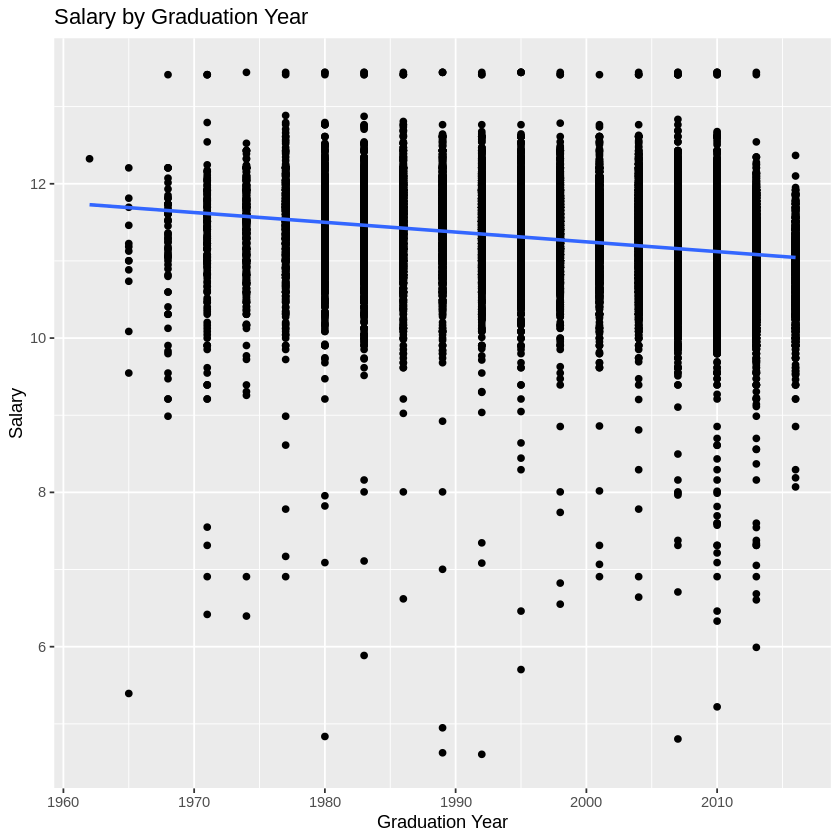

In [9]:
#plot salary scatter plot, see outliers
ggplot(filtered, aes(x=HDACY3, y=log(Salary)))+
  geom_point() +
  geom_smooth(method = "lm", se = FALSE) +
  labs(title = "Salary by Graduation Year",
       x = "Graduation Year",
       y = "Salary")

In [10]:
#remove too low values
filtered <- filtered %>%
  filter(Salary >= exp(9))

In [ ]:
write.csv(filtered, "filtered.csv") #save the processed data

## Explore the Data: Summary Statistics

Before proceeding to the empirical results, I will present a series of descriptive statistics of annual salary by fields of study and gender. All statistics in this section and the regression results in the later section are computed using weighted data.

In [8]:
filtered <- read.csv('filtered.csv')

In [9]:
#as survey
filtersurvey <- svydesign(id=~1, weights=~WTSURVY, data=filtered)

In [10]:
#summary statistics
t10 <- svyby(~Salary, ~AllMajor, filtersurvey, svymean)

t11 <- svyby(~Salary, ~AllMajor, filtersurvey, svyquantile, quantiles = c(0.25, 0.5, 0.75))

t12 <- filtersurvey %>% 
  tbl_svysummary(
    # Use include to select variables
    include = c(AllMajor),
    statistic = list(all_continuous()  ~ "{mean} ({sd})",
                     all_categorical() ~ "{n}    ({p}%)"),
    digits = list(
                  all_categorical() ~ c(0, 1))
  ) %>%
  modify_header(label = "**Fields of study**") %>%
  modify_caption("Estimated number and percentage of graduates by fields of study (weighted)") %>%
  bold_labels()

t10 <- data.frame(t10)
t11 <- data.frame(t11)
t12 <- data.frame(t12)
t12 <- t12[c(2,3,4,5,6,7,8,9,10,11), ]
table1 <- cbind(t10, t11,t12)


# stargazer(table1, type = "latex", digits = 0, summary = FALSE, 
#           column.labels = c("25th", "50th", "75th"), 
#           dep.var.caption = "Salary Quantiles by Major", 
#           dep.var.labels.include = FALSE,
#           keep=c(2,3,6,7,8,13)
#           )

`...` must be empty.
✖ Problematic arguments:
• optional = TRUE
• stringsAsFactors = stringsAsFactors


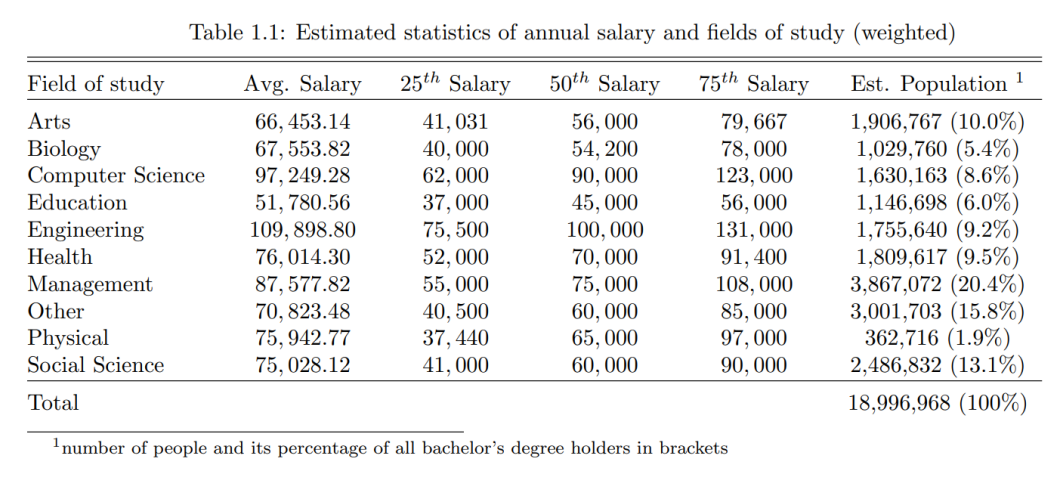

Table 1.1 describes the average and quantiles of annual salary by fields of study, along with the proportion of bachelor’s degree holders in each field.

Among all fields of study, graduates with a degree in Engineering have the highest average salary of \\$109,898.80 and the highest salary at each quantile. Engineering bachelor’s degree holders make up 9.2\% of all bachelor’s degree holders. This percentage is not at the top among all fields of study; however, it represents the highest proportion of degree holders within the realm of STEM fields: computer science constitutes 8.6\% of the total, biology makes up 5.4\% of the total, and physical only accounts for around 2\%. Interestingly, the lower quantile ($25^{th}$) salary of engineering graduates is higher than the median salary of all fields of study except for computer science, which, to some extent, implies how strong the engineering graduates' earnings are. 

Biology graduates have the lowest average annual salaries at \\$67,553.82 among STEM fields and the second lowest median annual salaries among all fields. The salary distribution of biology graduates is similar to that of arts graduates. Moreover, the salary of biology graduates at each quantile is \\$1,000 to \\$2,000 lower than that of arts graduates. With a slightly larger proportion of graduates (6\%) than biology (5.4\%), education degree holders have the lowest average and salaries at each quantile. The gap in salary between education graduates and other graduates is widening from lower to upper quantile. At the $75^{th}$ quantile, the salary of education graduates is only \\$56,000, which is \\$22,000 lower than the salary of biology graduates.

The majority of bachelor's degrees are concentrated in management (20.4\%), other (15.8\%) and social science (13.1\%). Individuals in these fields account for almost 50\% of all graduates.

In [7]:
table2 <- filtersurvey %>% 
  tbl_svysummary(
    by = GENDER,
    include = c(AllMajor),
    statistic = list(all_continuous()  ~ "{mean} ({sd})",
                     all_categorical() ~ "{n}    ({p}%)"),
    digits = list(
                  all_categorical() ~ c(0, 1))
  ) %>%
  modify_header(label = "**Gender**") %>%
  modify_caption("Estimated number and percentage of graduates by fields of study and gender(weighted)") %>%
  bold_labels()

table2 <- data.frame(table2)
table2 <- table2[c(2,3,4,5,6,7,8,9,10,11), ]

# stargazer(table2, type = "latex", digits = 0, summary = FALSE, 
#           column.labels = c("25th", "50th", "75th"), 
#           dep.var.caption = "Salary Quantiles by Major", 
#           dep.var.labels.include = FALSE,
#           keep = c(2,3,4)
#           )

`...` must be empty.
✖ Problematic arguments:
• optional = TRUE
• stringsAsFactors = stringsAsFactors


In [8]:
table3 <- data.frame(table3)
table3 <- table3[c(2,3), ]
rownames(table3) <- table3$Fields

table3 <- table3[, -which(names(table3) == "Fields")]

t33 <- t(table3)
# stargazer(t33, type = "latex", digits = 2, summary = FALSE, 
#           column.labels = c("25th", "50th", "75th"), 
#           dep.var.caption = "Salary Quantiles by Major", 
#           dep.var.labels.include = FALSE
#           )

In [9]:
table3 <- filtersurvey %>% 
  tbl_svysummary(
    # Use include to select variables
    by = AllMajor,
    include = c(GENDER),
    statistic = list(#all_continuous()  ~ "{mean} ({sd})",
                     all_categorical() ~ "{n}    ({p}%)"),
                     #all_categorical() ~ "({p}%)"),
    digits = list(
                  all_categorical() ~ c(0, 1))
  ) %>%
  modify_header(label = "Fields") %>%
  modify_caption("Estimated ratio of graduates in each gender by fields of study (weighted)") %>%
  bold_labels()


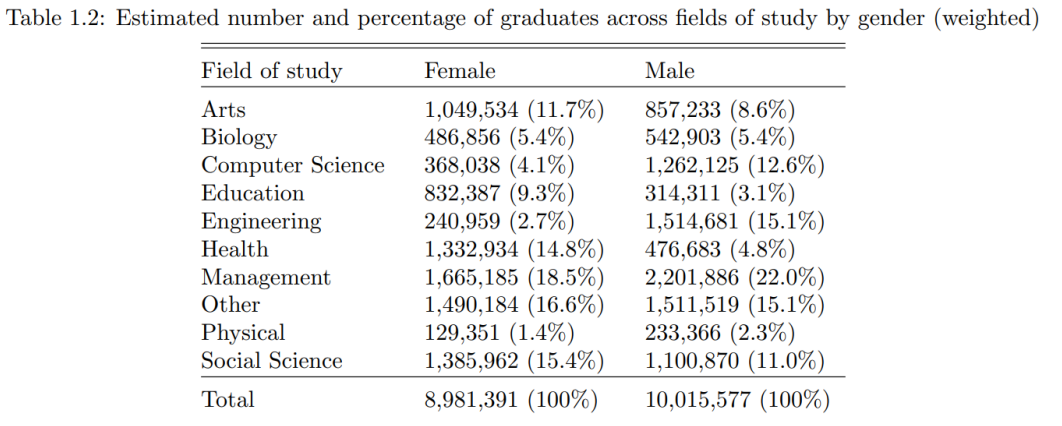

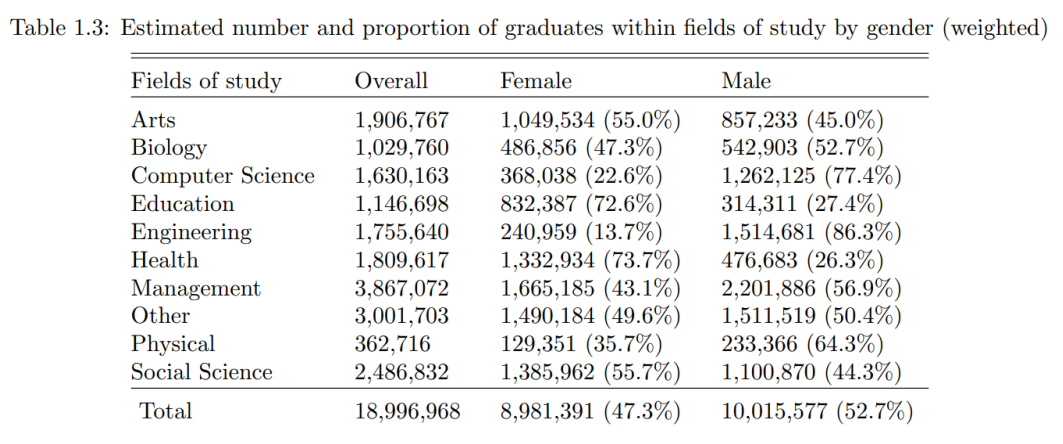

Table 1.2 and Table 1.3 incorporate gender to examine the distribution of fields of study within and between genders. The weighted population is 18,996,968, with 47.3\% females and 52.7\% males.

From Table 1.2, the fields of study in which males and females are concentrated differ. The majority of female college graduates obtain degrees in non-STEM fields such as management, social science, health, and arts. The percentage of females with a degree in biology, computer science, engineering, and physical is only 13.6\%; furthermore, biology contributes the most to this percentage. As illustrated by Table 1.1 previously, biology graduates have the lowest average salary among STEM fields. On the contrary, around 35\% of male graduates obtained a STEM degree, most majoring in computer science or engineering. Compared to males, a higher percentage of females are concentrated in fields with middle to low earnings, including health, social science, arts and education. In particular, 9.3\% of female bachelor’s degree holders obtained a degree in education, three times the percentage of males with education degrees. Given the analysis of Table 1.1, it will be reasonable to anticipate gender earnings differentials in light of the different distribution of college graduates in fields of study, especially those fields with top salaries and bottom salaries.

As a complement, Table 1.3 provides a more intuitive description of gender dominance in each field. The most explicit heterogeneity is in engineering, where only 13.7\% of the degree holders are female. That is, there is only one female in every eight engineering graduates. While the percentage of female bachelor's degree holders in computer science is higher at 22.6\% compared to engineering, it remains significantly lower than that of males. Females dominate in health and education, constituting over 70\% of degree holders in these fields. For arts, biology, management, and social science, the ratio of females to males is more uniform, with some fields having slightly more males while others have slightly more females.

### Gender Specific

Table 1.4 is a summary of average salary within each gender.

In [10]:
filteredF <- filtered %>%
  filter(Female == 1)

filteredM <- filtered %>%
  filter(Female == 0)

filteredF <- svydesign(id=~1, weights=~WTSURVY, data=filteredF)
filteredM <- svydesign(id=~1, weights=~WTSURVY, data=filteredM)

In [11]:
tF <- svyby(~Salary, ~AllMajor, filteredF, svymean)
tM <- svyby(~Salary, ~AllMajor, filteredM, svymean)

tF <- data.frame(tF)
tM <- data.frame(tM)

tF <- tF[ , c(1,2,3)]
tM <- tM[ , c(1,2,3)]

tableFM <- cbind(tF, tM)


# stargazer(tableFM, type = "latex", digits = 0, summary = FALSE, 
#           dep.var.labels.include = FALSE,
#           keep=c(2,3,4,6,7)
#           )

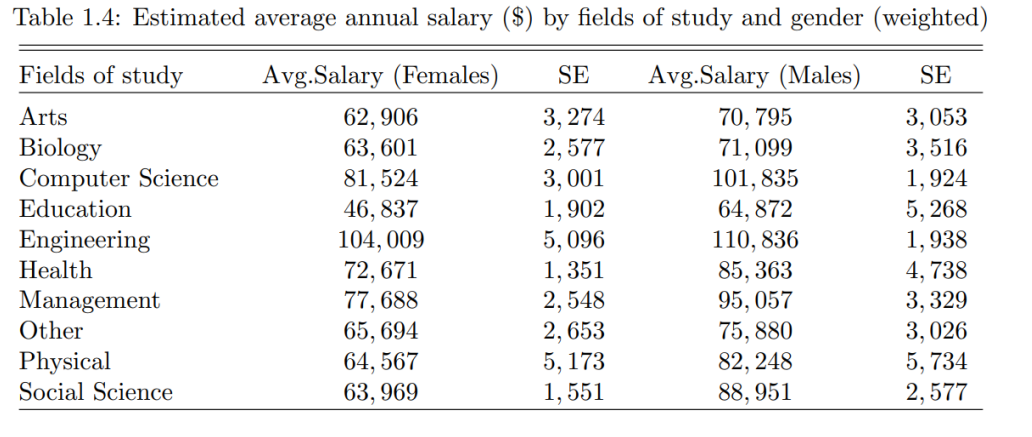

## OLS Regression Models

The proposed model for analysis is the ordinary least squares regression with multiple regressors. The initial dependent variable is the annual salary in 2019 dollars. However, the original salary in dollars does not satisfy the normality assumption of applying OLS. Therefore, I transformed the annual salary to the log scale so that the model fits better for the response variable $ln\left(Salary\right)$.

### An Overall Picture of Fields of Study and Earnings Inequality

**OLS Model 1**

$$
ln(Annual Salary) = \beta_0 + \beta_{i} FOS_i + \gamma_j X_j + \epsilon_{ij}
$$

$$FOS_i = \{CompSci, Biology, Physical, Engineering, Health, Management, Education, Arts, Other\}
$$

$$
X_j = \{Age,Gender, Race, Graduation Year, Parents Education Level...\}
$$

The independent variable $FOS_i$ is fields of study for bachelor's degree. I categorize majors into ten fields: (1) Computer and mathematics sciences; (2) Engineering; (3) Physical, chemistry and related sciences; (4) Biological and environmental life sciences; (5) Social sciences, including majors such as economics, sociology and psychology; (6) Arts and humanities; (7) Health; (8) Management and administration; (9) Education, including both science and math teacher education and non-science and math teacher education; (10) Other fields, including social service, sales and marketing and other related fields. For short, I label these ten fields as$
CompSci,\ Engineering,\ Physical,\ Biology,\ SocialSci,\ Arts,Health,\ 
Management,\ Education,\ Oth$er


The coefficients of interest are $\beta_i$’s.$X_j$ is a set of covariates, including age, minority, disability, citizenship, parents’ education level, and whether the degree was obtained from a private college. Those factors will likely impact individual earnings and should be controlled to avoid omitted variable bias. Age can partially indicate work experience, as older individuals tend to have more work experience than young graduates. Minority, disability, and citizenship are potential factors that may bring discrimination to earnings. Minority is 1 for races other than White and Asian, disability is 1 for disabled individuals, and citizenship is 1 for native or naturalized U.S. citizens; otherwise, it is 0. Parents’ education level and graduation from private college have implications on family income, which may be associated with individual earnings.I create two indicators, $HSDAD$ and $HSMOM$, assigning a value of 1 if the parent’s education is high school or below, and 0 otherwise. $Private$ is 1 when a person graduated from a private college.


In [11]:
lnmajor <- svyglm(log(Salary)~CompSci + Biology + Physical+Engineering+Health+Management+Education
            +Arts+Other
            , filtersurvey)
summary(lnmajor)


Call:
svyglm(formula = log(Salary) ~ CompSci + Biology + Physical + 
    Engineering + Health + Management + Education + Arts + Other, 
    design = filtersurvey)

Survey design:
svydesign(id = ~1, weights = ~WTSURVY, data = filtered)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 11.03921    0.01753 629.620  < 2e-16 ***
CompSci      0.31470    0.02676  11.760  < 2e-16 ***
Biology     -0.10308    0.02999  -3.437 0.000589 ***
Physical     0.03007    0.05830   0.516 0.605960    
Engineering  0.44930    0.02198  20.439  < 2e-16 ***
Health       0.09682    0.02700   3.585 0.000337 ***
Management   0.18994    0.02857   6.648 3.02e-11 ***
Education   -0.29628    0.03594  -8.244  < 2e-16 ***
Arts        -0.07991    0.03627  -2.203 0.027617 *  
Other       -0.02298    0.03298  -0.697 0.485829    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.2830936)

Number of Fisher Scoring iterati

In [12]:
lnmajorage <- svyglm(log(Salary)~CompSci + Biology + Physical+Engineering+Health+Management+Education
            +Arts+Other+Age
            , filtersurvey)
summary(lnmajorage)


Call:
svyglm(formula = log(Salary) ~ CompSci + Biology + Physical + 
    Engineering + Health + Management + Education + Arts + Other + 
    Age, design = filtersurvey)

Survey design:
svydesign(id = ~1, weights = ~WTSURVY, data = filtered)

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.5900765  0.0309783 341.854  < 2e-16 ***
CompSci      0.2913248  0.0262813  11.085  < 2e-16 ***
Biology     -0.0876814  0.0283799  -3.090  0.00201 ** 
Physical     0.0339935  0.0488332   0.696  0.48636    
Engineering  0.4250705  0.0211501  20.098  < 2e-16 ***
Health       0.0755336  0.0255531   2.956  0.00312 ** 
Management   0.1430423  0.0282908   5.056 4.31e-07 ***
Education   -0.3550231  0.0367801  -9.653  < 2e-16 ***
Arts        -0.0837837  0.0332530  -2.520  0.01176 *  
Other       -0.0381680  0.0300029  -1.272  0.20333    
Age          0.0112884  0.0006827  16.536  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion par

In [13]:
lnmajorcontrol <- svyglm(log(Salary)~CompSci + Biology+Physical+Engineering+Health+
                     Management+Education+Arts+Other + Age + Minority + Disable 
                   + Citizen, filtersurvey)
summary(lnmajorcontrol)


Call:
svyglm(formula = log(Salary) ~ CompSci + Biology + Physical + 
    Engineering + Health + Management + Education + Arts + Other + 
    Age + Minority + Disable + Citizen, design = filtersurvey)

Survey design:
svydesign(id = ~1, weights = ~WTSURVY, data = filtered)

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.5904603  0.0508702 208.186  < 2e-16 ***
CompSci      0.2850638  0.0265120  10.752  < 2e-16 ***
Biology     -0.1001933  0.0283682  -3.532 0.000413 ***
Physical     0.0128568  0.0501664   0.256 0.797734    
Engineering  0.4162951  0.0216846  19.198  < 2e-16 ***
Health       0.0677488  0.0258631   2.620 0.008811 ** 
Management   0.1397155  0.0279274   5.003 5.69e-07 ***
Education   -0.3684782  0.0361668 -10.188  < 2e-16 ***
Arts        -0.0947269  0.0339261  -2.792 0.005240 ** 
Other       -0.0414418  0.0292581  -1.416 0.156664    
Age          0.0110730  0.0006842  16.185  < 2e-16 ***
MinorityY   -0.1748177  0.0198863  -8.791  < 2e-16 *

Table 2.1 reveals the overall pattern of fields of study and earnings inequality using weighted data. There are four stages of regression, and each stage contains different regressors: stage (1) includes only fields of study but no covariates; stage (2) adds age as the covariate; stage (3) adds three additional control variables, minority, disability and citizen; stage (4) further includes parents’ education level and private college. The omitted field of study is social science ($SocialSci$). The following interpretation of coefficients takes social science bachelor’s degree holders as the reference group. 

In all four stages, the estimated coefficients for computer science, engineering, health and management are significant and positive, while the estimated coefficients for biology, education and arts are significant and negative. This indicates that whether controlling for demographic and family background, college graduates with degrees in computer science, engineering, health and management earn more on average compared to the reference group (social science graduates). On the contrary, biology, education and arts graduates earn less on average compared to the reference group. We may consider this a “boost” or “penalty” on earnings by a field of study. Note that the analysis below only implies the magnitude of the effect and does not represent a percentage “boost” or “penalty” on salary.

Among all fields of study, engineering has the highest boost effect of 0.449 on annual salary compared to the reference group, and this effect slightly decreases to 0.413 after adding complete control in stage (4) but is still the highest among all fields. Computer science also has a noticeable high boost effect of 0.315 in stage (1) and 0.282 in stage (2) after control. Not all STEM fields have a positive effect on salary. A degree in biology has around a -0.1 penalty on the salary, which is greater than the penalty of -0.095 associated with a degree in arts. A degree in education has the most considerable penalty effect on salary among all fields, which is -0.296 in stage (1). After controlling for age in stage (2), this penalty effect increases by 0.06 and becomes -0.355, similar to the estimate in stage (4). For graduates with similar demographics and family backgrounds, a degree in education has a considerable negative impact on earnings, which are three or more times higher than the penalty for a degree in biology or arts. 

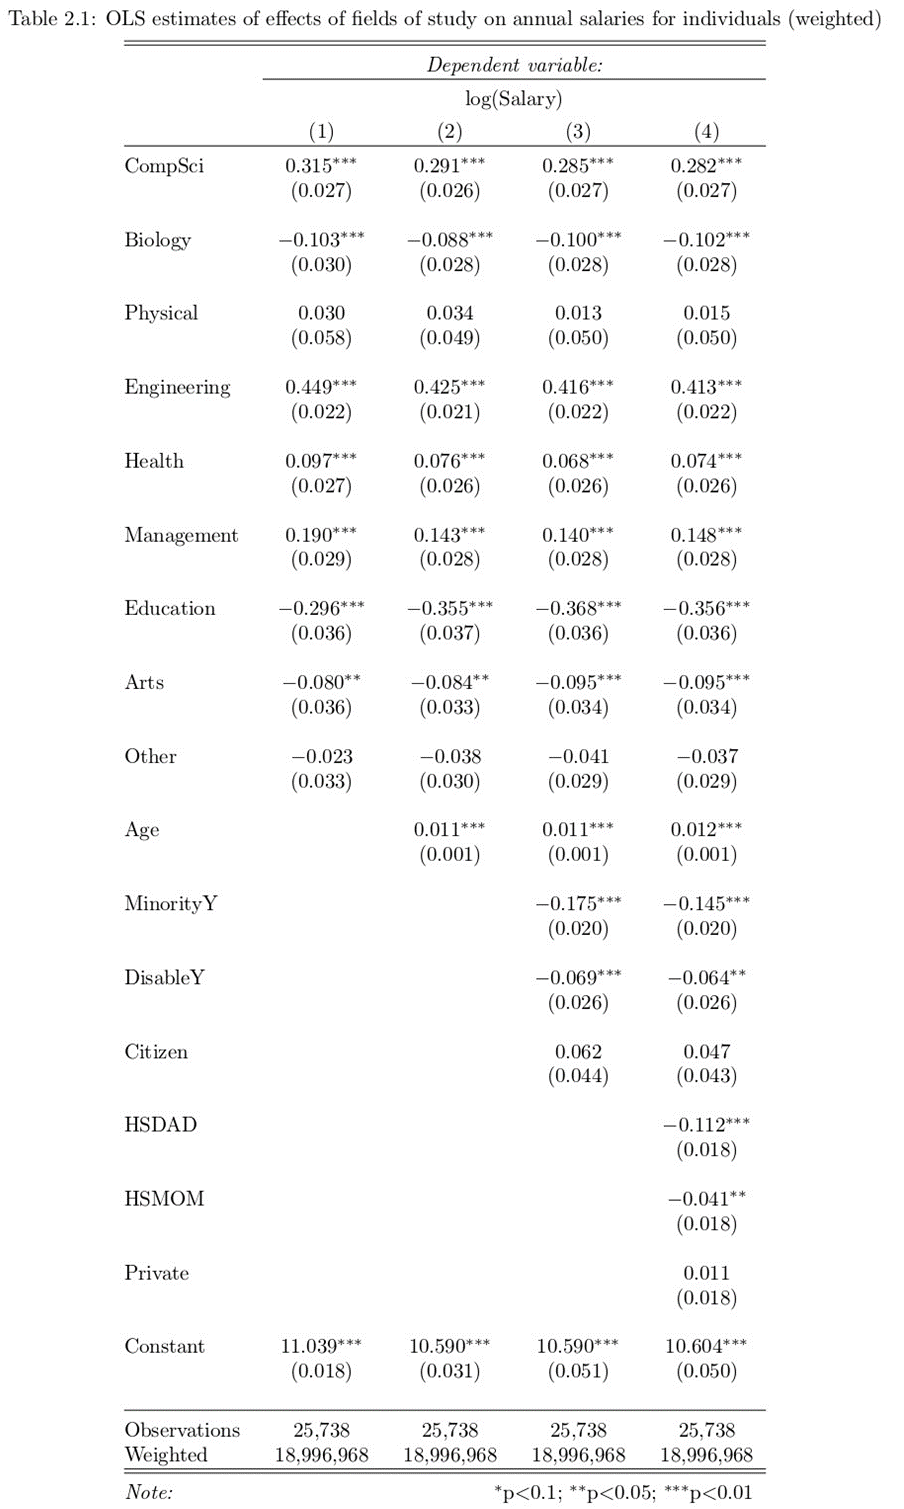

Overall, it can be observed that among college graduates with similar demographics and family backgrounds, fields of study have extremely diverse effects on earnings. Individuals with a degree in some traditional STEM fields, such as engineering and computer science, tend to have strong earnings. In contrast, other STEM fields, such as physics and biology, have a negligible positive effect or even penalty on earnings. For non-STEM fields, health and management show significant yet comparatively lower bonus effects on earnings. At the same time, a degree in education exhibits a noteworthy negative correlation with earnings, exceeding three times the negative effect on salary associated with a degree in arts.

### Fields of Study and Earnings Differentials by Gender

To study the within-gender earnings inequality, I subset the 25,738 observations into female and male groups with 9,940 and 15,798 observations, respectively. The results based on weighted data are shown in Table 2.2. Model (F1) and (F2) are regression against females, and model (M1) and (M2) are against males. The reference group is social science graduates of each gender, aligned with the previous. We may think of a positive coefficient as better earnings compared to the social science graduates of the same gender and vice versa.

In [16]:
filteredF <- filtered %>%
  filter(Female == 1)

filteredM <- filtered %>%
  filter(Female == 0)

filteredF <- svydesign(id=~1, weights=~WTSURVY, data=filteredF)
filteredM <- svydesign(id=~1, weights=~WTSURVY, data=filteredM)

In [17]:
F1 <- svyglm(log(Salary)~CompSci + Biology+Physical+Engineering+Health+
                     Management+Education+Arts+Other 
            , filteredF)
summary(F1)


Call:
svyglm(formula = log(Salary) ~ CompSci + Biology + Physical + 
    Engineering + Health + Management + Education + Arts + Other, 
    design = filteredF)

Survey design:
svydesign(id = ~1, weights = ~WTSURVY, data = filteredF)

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.9075612  0.0220048 495.691  < 2e-16 ***
CompSci      0.2612971  0.0515380   5.070 4.05e-07 ***
Biology     -0.0090925  0.0403986  -0.225    0.822    
Physical     0.0386386  0.0741069   0.521    0.602    
Engineering  0.5158919  0.0448766  11.496  < 2e-16 ***
Health       0.2011103  0.0292883   6.867 6.97e-12 ***
Management   0.2202797  0.0421168   5.230 1.73e-07 ***
Education   -0.2406276  0.0389182  -6.183 6.54e-10 ***
Arts         0.0008263  0.0500079   0.017    0.987    
Other        0.0339713  0.0457138   0.743    0.457    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.2566369)

Number of Fi

In [18]:
F2 <- svyglm(log(Salary)~CompSci + Biology+Physical+Engineering+Health+
                     Management+Education+Arts+Other + Age + Minority + Disable + Citizen, filteredF)
summary(F2)


Call:
svyglm(formula = log(Salary) ~ CompSci + Biology + Physical + 
    Engineering + Health + Management + Education + Arts + Other + 
    Age + Minority + Disable + Citizen, design = filteredF)

Survey design:
svydesign(id = ~1, weights = ~WTSURVY, data = filteredF)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.43969    0.08969 116.395  < 2e-16 ***
CompSci      0.22207    0.05165   4.300 1.73e-05 ***
Biology     -0.01749    0.03973  -0.440  0.65985    
Physical     0.02977    0.06563   0.454  0.65006    
Engineering  0.51571    0.04361  11.824  < 2e-16 ***
Health       0.15941    0.02838   5.616 2.00e-08 ***
Management   0.17406    0.04215   4.129 3.67e-05 ***
Education   -0.32011    0.04039  -7.926 2.51e-15 ***
Arts        -0.01458    0.04545  -0.321  0.74834    
Other        0.01791    0.04076   0.439  0.66033    
Age          0.01052    0.00100  10.520  < 2e-16 ***
MinorityY   -0.12491    0.02885  -4.330 1.51e-05 ***
DisableY    -0.12864    0

In [19]:
F3 <- svyglm(log(Salary)~CompSci + Biology+Physical+Engineering+Health+
                     Management+Education+Arts+Other + Age + Minority + Disable + Citizen + HSDAD + HSMOM + Private, filteredF)
summary(F3)


Call:
svyglm(formula = log(Salary) ~ CompSci + Biology + Physical + 
    Engineering + Health + Management + Education + Arts + Other + 
    Age + Minority + Disable + Citizen + HSDAD + HSMOM + Private, 
    design = filteredF)

Survey design:
svydesign(id = ~1, weights = ~WTSURVY, data = filteredF)

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.455609   0.088905 117.604  < 2e-16 ***
CompSci      0.221793   0.051421   4.313 1.62e-05 ***
Biology     -0.017977   0.039711  -0.453  0.65078    
Physical     0.043076   0.062360   0.691  0.48973    
Engineering  0.497856   0.043077  11.557  < 2e-16 ***
Health       0.164256   0.028304   5.803 6.70e-09 ***
Management   0.185935   0.042574   4.367 1.27e-05 ***
Education   -0.311396   0.039320  -7.919 2.64e-15 ***
Arts        -0.012181   0.044425  -0.274  0.78394    
Other        0.025684   0.040472   0.635  0.52570    
Age          0.011499   0.001003  11.460  < 2e-16 ***
MinorityY   -0.092940   0.029244  -

In [20]:
M1 <- svyglm(log(Salary)~CompSci + Biology+Physical+Engineering+Health+
                     Management+Education+Arts+Other 
            , filteredM)
summary(M1)


Call:
svyglm(formula = log(Salary) ~ CompSci + Biology + Physical + 
    Engineering + Health + Management + Education + Arts + Other, 
    design = filteredM)

Survey design:
svydesign(id = ~1, weights = ~WTSURVY, data = filteredM)

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 11.204945   0.025051 447.285  < 2e-16 ***
CompSci      0.202926   0.032906   6.167 7.14e-10 ***
Biology     -0.235053   0.043117  -5.452 5.07e-08 ***
Physical    -0.067446   0.083452  -0.808 0.418992    
Engineering  0.293908   0.028741  10.226  < 2e-16 ***
Health       0.007563   0.061662   0.123 0.902382    
Management   0.100823   0.037889   2.661 0.007799 ** 
Education   -0.260779   0.073236  -3.561 0.000371 ***
Arts        -0.183308   0.049094  -3.734 0.000189 ***
Other       -0.115087   0.045652  -2.521 0.011714 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.2918653)

Number of Fisher Scorin

In [21]:
M2 <- svyglm(log(Salary)~CompSci + Biology+Physical+Engineering+Health+
                     Management+Education+Arts+Other + Age + Minority + Disable + Citizen, filteredM)
summary(M2)


Call:
svyglm(formula = log(Salary) ~ CompSci + Biology + Physical + 
    Engineering + Health + Management + Education + Arts + Other + 
    Age + Minority + Disable + Citizen, design = filteredM)

Survey design:
svydesign(id = ~1, weights = ~WTSURVY, data = filteredM)

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.7680569  0.0619550 173.805  < 2e-16 ***
CompSci      0.1901462  0.0320577   5.931 3.07e-09 ***
Biology     -0.2186176  0.0393018  -5.563 2.70e-08 ***
Physical    -0.0838420  0.0703781  -1.191 0.233550    
Engineering  0.2692051  0.0277313   9.708  < 2e-16 ***
Health      -0.0025849  0.0580304  -0.045 0.964472    
Management   0.0542632  0.0365773   1.484 0.137956    
Education   -0.3011050  0.0696241  -4.325 1.54e-05 ***
Arts        -0.1971687  0.0480766  -4.101 4.13e-05 ***
Other       -0.1353887  0.0403806  -3.353 0.000802 ***
Age          0.0111228  0.0009271  11.998  < 2e-16 ***
MinorityY   -0.2059787  0.0263790  -7.808 6.15e-15 ***

In [22]:
M3 <- svyglm(log(Salary)~CompSci + Biology+Physical+Engineering+Health+
                     Management+Education+Arts+Other + Age + Minority + Disable + Citizen + HSDAD + HSMOM + Private, filteredM)
summary(M3)


Call:
svyglm(formula = log(Salary) ~ CompSci + Biology + Physical + 
    Engineering + Health + Management + Education + Arts + Other + 
    Age + Minority + Disable + Citizen + HSDAD + HSMOM + Private, 
    design = filteredM)

Survey design:
svydesign(id = ~1, weights = ~WTSURVY, data = filteredM)

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.7753729  0.0607020 177.513  < 2e-16 ***
CompSci      0.1890341  0.0319742   5.912 3.45e-09 ***
Biology     -0.2188074  0.0387785  -5.642 1.70e-08 ***
Physical    -0.0845661  0.0698622  -1.210  0.22612    
Engineering  0.2717221  0.0272045   9.988  < 2e-16 ***
Health       0.0036715  0.0574744   0.064  0.94907    
Management   0.0597434  0.0355089   1.682  0.09249 .  
Education   -0.2808241  0.0698604  -4.020 5.85e-05 ***
Arts        -0.2010596  0.0485144  -4.144 3.43e-05 ***
Other       -0.1330691  0.0399199  -3.333  0.00086 ***
Age          0.0123584  0.0009564  12.922  < 2e-16 ***
MinorityY   -0.1813813 

The patterns are interestingly different for females and males. For females, a computer science, engineering, health or management degree significantly affects salary. In particular, the bonus effect of engineering on earnings for females is dramatically high, at 0.516 without control and 0.498 after control for demographic and family backgrounds. The magnitude of the after-control bonus effect is greater than the coefficients for engineering in the overall result shown in Table 2.1, regardless of stages. Education is the only field with a significant penalty on salary for females, and the penalty effect grows to -0.311 after adding control variables in (F2). It is worth noticing that education also has a significant penalty effect on salary for males, yet the effect of -0.281 in (M2) is smaller than for females. By combining the lower mean salary for the female reference group (see Table 1.4) and the higher penalty for a degree in education, women with an education degree face the most pronounced disadvantage in earnings.

For males, a degree in computer science or engineering has a significant but minor boost effect on earnings compared to the effect for females. However, other fields except management either have significant penalty effects or non-significant effects on earnings. Males with a degree in biology or arts face a significant penalty effect of more than -0.2 on earnings, while the penalty is not statistically significant for female graduates with a degree in biology or arts. The coefficients for biology and arts in (M2) are almost double the coefficients (around -0.1) in Table 2.1. This is possible because male social science graduates as the reference group have better earnings than overall social science graduates (see Table 1.4), so the bonus effect of majoring in computer science or engineering shrinks, but the penalty effect of majoring in other fields increases relative to the overall result.
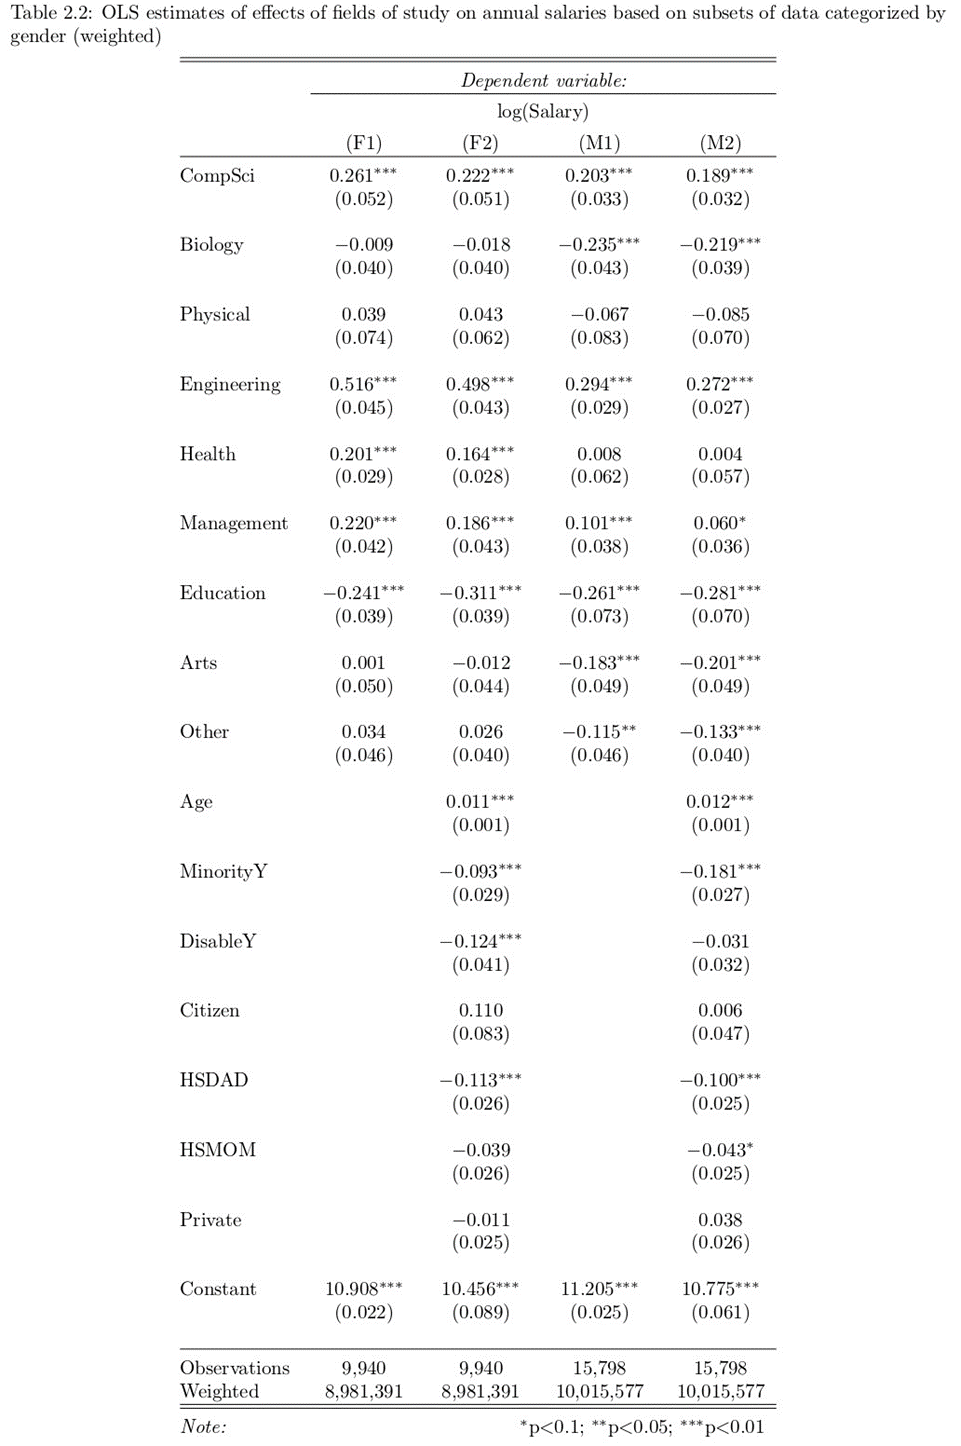


With social science graduates of the same gender as a reference, females benefit more in earnings from a degree in engineering or computer science but suffer the greater penalty of a degree in education. Males with a degree in fields other than computer science or engineering tend to have no advantage or disadvantage in earnings compared to males in the reference group. 

### Interaction of fields of study and gender

To analyze between-gender earnings inequality, I draw on the previous study by Morgan (2008) and tweak the model (1) that is previously specified by adding an interaction term:

$$
ln(Annual Salary) = \beta_0 + \beta_{1i} Female:FOS_i + \beta_{2i}FOS_i + \gamma_j X_j + \epsilon_{ij}
$$

In this model, 𝐹𝑒𝑚𝑎𝑙𝑒 is an indicator of whether an individual is female; $Female:FOS_i$ is the interaction term of gender and fields of study; $β_{1𝑖}$ is the coefficient of interest to examine between-gender earnings inequality by fields of study.

In [14]:
gender <- svyglm(log(Salary) ~ CompSci:Female + Arts:Female + Biology:Female + 
    Engineering:Female + Physical:Female + Health:Female + Management:Female + 
    Education:Female + Other:Female + SocialSci:Female + 
    CompSci + Biology + Physical + Engineering + Health + Management + 
    Education + Arts + Other , design=filtersurvey)
summary(gender)


Call:
svyglm(formula = log(Salary) ~ CompSci:Female + Arts:Female + 
    Biology:Female + Engineering:Female + Physical:Female + Health:Female + 
    Management:Female + Education:Female + Other:Female + SocialSci:Female + 
    CompSci + Biology + Physical + Engineering + Health + Management + 
    Education + Arts + Other, design = filtersurvey)

Survey design:
svydesign(id = ~1, weights = ~WTSURVY, data = filtered)

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        11.204945   0.025051 447.291  < 2e-16 ***
CompSci             0.202926   0.032906   6.167 7.07e-10 ***
Biology            -0.235053   0.043116  -5.452 5.04e-08 ***
Physical           -0.067446   0.083451  -0.808 0.418981    
Engineering         0.293908   0.028741  10.226  < 2e-16 ***
Health              0.007563   0.061662   0.123 0.902380    
Management          0.100823   0.037889   2.661 0.007795 ** 
Education          -0.260779   0.073235  -3.561 0.000370 ***
Arts          

In [24]:
gendercontrol <- svyglm(log(Salary) ~ CompSci:Female + Arts:Female + Biology:Female + 
    Engineering:Female + Physical:Female + Health:Female + Management:Female + 
    Education:Female + Other:Female + SocialSci:Female + 
    CompSci + Biology + Physical + Engineering + Health + Management + 
    Education + Arts + Other + Age + Minority + Disable + Citizen, design=filtersurvey)
summary(gendercontrol)


Call:
svyglm(formula = log(Salary) ~ CompSci:Female + Arts:Female + 
    Biology:Female + Engineering:Female + Physical:Female + Health:Female + 
    Management:Female + Education:Female + Other:Female + SocialSci:Female + 
    CompSci + Biology + Physical + Engineering + Health + Management + 
    Education + Arts + Other + Age + Minority + Disable + Citizen, 
    design = filtersurvey)

Survey design:
svydesign(id = ~1, weights = ~WTSURVY, data = filtered)

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)        10.7440507  0.0538778 199.415  < 2e-16 ***
CompSci             0.1941569  0.0319655   6.074 1.27e-09 ***
Biology            -0.2163523  0.0392941  -5.506 3.71e-08 ***
Physical           -0.0762525  0.0711559  -1.072 0.283898    
Engineering         0.2746255  0.0275352   9.974  < 2e-16 ***
Health              0.0002252  0.0590488   0.004 0.996958    
Management          0.0582302  0.0366110   1.591 0.111732    
Education          -0.298

In [25]:
gendercontrol2 <- svyglm(log(Salary) ~ CompSci:Female + Arts:Female + Biology:Female + 
    Engineering:Female + Physical:Female + Health:Female + Management:Female + 
    Education:Female + Other:Female + SocialSci:Female + 
    CompSci + Biology + Physical + Engineering + Health + Management + 
    Education + Arts + Other + Age + Minority + Disable + Citizen +
    HSDAD + HSMOM + Private, design=filtersurvey)
summary(gendercontrol2)


Call:
svyglm(formula = log(Salary) ~ CompSci:Female + Arts:Female + 
    Biology:Female + Engineering:Female + Physical:Female + Health:Female + 
    Management:Female + Education:Female + Other:Female + SocialSci:Female + 
    CompSci + Biology + Physical + Engineering + Health + Management + 
    Education + Arts + Other + Age + Minority + Disable + Citizen + 
    HSDAD + HSMOM + Private, design = filtersurvey)

Survey design:
svydesign(id = ~1, weights = ~WTSURVY, data = filtered)

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)        10.7542267  0.0531771 202.234  < 2e-16 ***
CompSci             0.1935515  0.0318879   6.070 1.30e-09 ***
Biology            -0.2186938  0.0388367  -5.631 1.81e-08 ***
Physical           -0.0793333  0.0712364  -1.114  0.26543    
Engineering         0.2759094  0.0270850  10.187  < 2e-16 ***
Health              0.0064175  0.0586402   0.109  0.91286    
Management          0.0654860  0.0357097   1.834  0.06669 .  

The result in Table 2.3 omits the main effect of $FOS_i$ variables for readability. First, the interaction effect of being female and having a degree in engineering on earnings is statistically significant at the 0.05 level in stage (1), where control variables are absent. However, it is not significant after controlling for demographics in stage (2). This indicates that for engineering graduates, females have almost no disadvantages in earnings compared to males, holding other factors constant. This aligns with the previous finding that females benefit more from a degree in engineering. Computer science does not have similar patterns as engineering in this case since being female has a significant penalty effect on salary compared to males, and the magnitude of this effect is relatively large at around -0.24. This corresponds to a large gender pay gap in computer science graduates in descriptive statistics. This is surprising from the perspective of skills and job characteristics since a computer science major is considered to have a tighter link to jobs in terms of the skills acquired from college (Morgan 2008).

Social science has the second largest penalty effect of being female on earnings at around -0.25, controlling for demographic and family background in stage (3). The connection between skills and jobs may also explain this: discrimination tends to be more prevalent when a degree has less obvious characteristics associated with the positions they are qualified for (Morgan 2008). For instance, a woman with a bachelor's degree in social science or arts may be likelier and easier to be assigned to a low-paying job such as an administrative role than a woman with a computer science or engineering degree.
Education has the highest negative effect after controlling for demographics in stage (2). Most other fields have seen a decrease in the magnitude of the coefficient after controlling for demographic and family background; however, the magnitude of the coefficient increased for education after adding a complete set of control variables. This implies a wide gender earnings gap for education degree holders. Penalties on earnings for arts, biology and physics are not statistically significant after controlling in stage (3)

.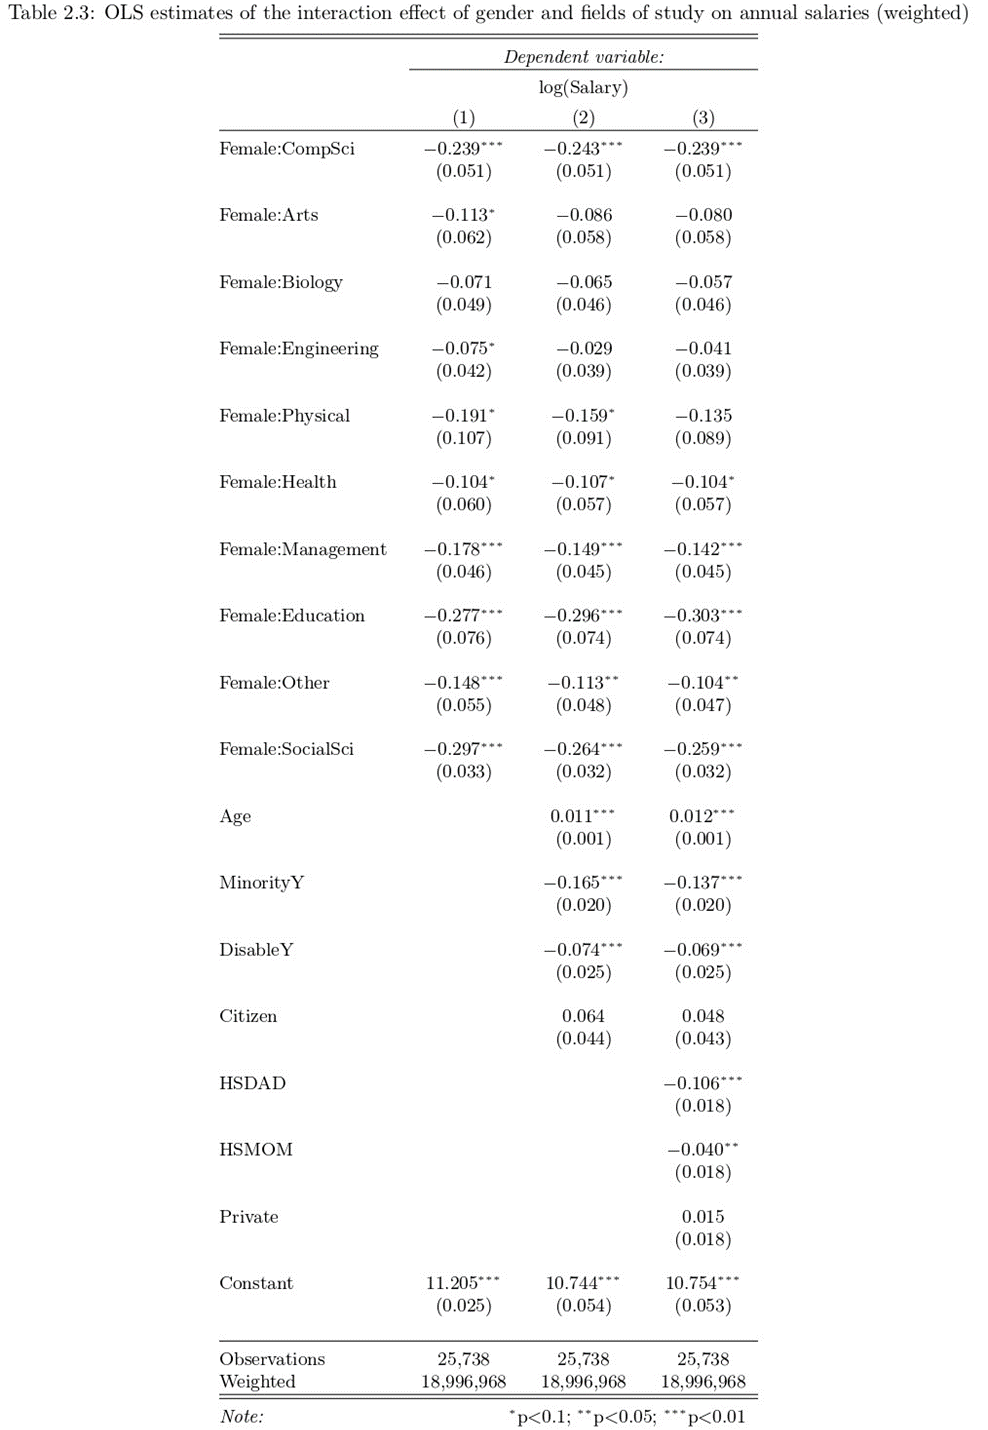


For predominately female fields, males may experience a glass escalator effect and obtain higher salaries (Wilson et al. 2017), while for predominately male fields, the best outcome for women is to have “no disadvantage” in earnings, which possibly depends on whether there is a strong connection between the degree characteristics and job characteristics. More commonly, women tend to experience varying degrees of disadvantage in both female-dominated and male-dominated fields.

## Visualize the Results

The empirical findings indicate that fields of study have varied impacts on earnings. STEM fields tend to have significant bonus effects or mild penalty effects on earnings, while non-STEM fields have mostly mild bonus effects and dramatic penalty effects on earnings (e.g., a degree in education). It further proves the significance of considering fields of study as a horizontal dimension when discussing the association between education and earnings inequality since earnings are not uniform for college graduates.

Instead of text and tables, proper visualizations can convey the findings more effectively and vividly.

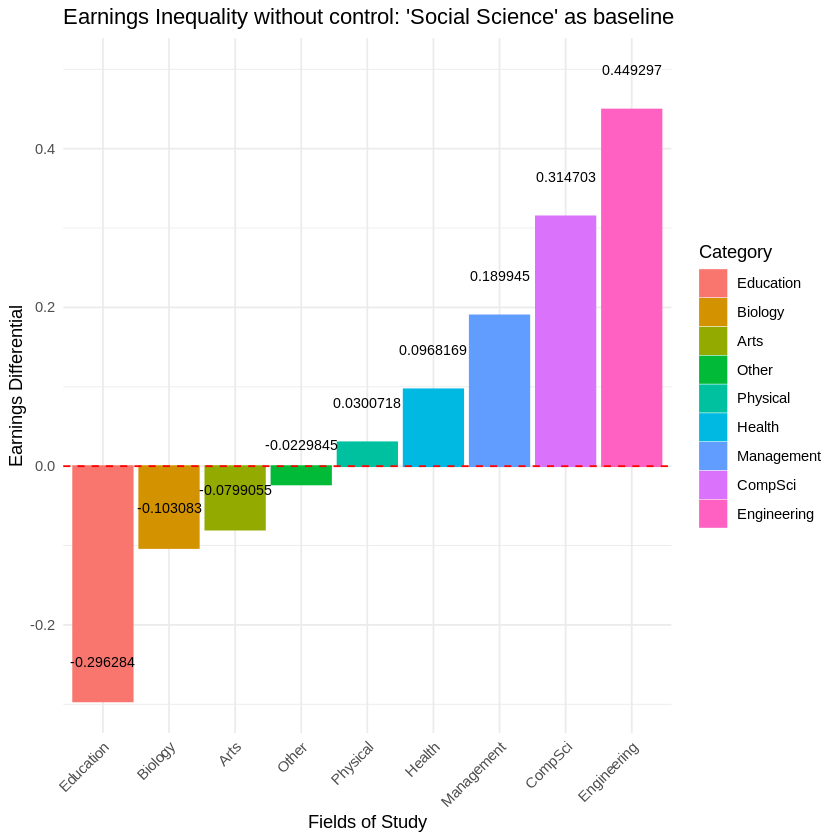

In [14]:
majcof <- lnmajor$coefficients[2:10] 
baseline <- 0


majcof <- data.frame(Category = names(majcof), Value = majcof)


t_shift <- scales::trans_new("shift",
                             transform = function(x) {x-baseline},
                             inverse = function(x) {x+baseline})
majcof$Category <- factor(majcof$Category, levels=majcof$Category[order(majcof$Value)])


ggplot(majcof, aes(x = reorder(Category,Value), y = (Value+baseline), fill = Category, colour = Category)) + 
  geom_bar(stat="identity") +
  scale_y_continuous(trans = t_shift, label=comma)+
  geom_hline(yintercept = baseline, linetype = "dashed", color = "red") +
  labs(title = "Earnings Inequality without control: 'Social Science' as baseline", x = "Fields of Study", y = "Earnings Differential") +
  geom_text(aes(label = signif(Value)), nudge_y = 0.05, vjust = 0.5, color="black", size=3)+
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


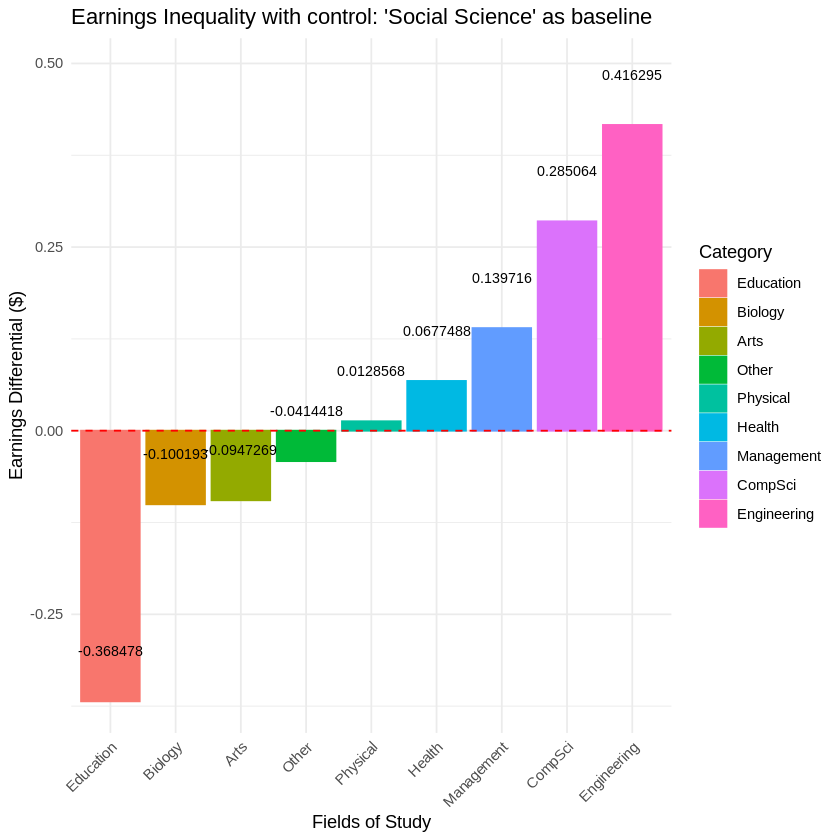

In [15]:
majctrl <- lnmajorcontrol$coefficients[2:10]

baselinectrl <- 0

majctrl <- data.frame(Category = names(majctrl), Value = majctrl)

majctrl$Category <- factor(majctrl$Category, levels=majctrl$Category[order(majctrl$Value)])

ggplot(majctrl, aes(x = reorder(Category,Value), y = Value, fill = Category, colour = Category)) + 
  geom_bar(stat="identity") +
  scale_y_continuous(label=comma)+
  geom_hline(yintercept = baselinectrl, linetype = "dashed", color = "red") +
  labs(title = "Earnings Inequality with control: 'Social Science' as baseline", x = "Fields of Study", y = "Earnings Differential ($)") +
  geom_text(aes(label = signif(Value)), nudge_y = 0.075, vjust = 1, color="black", size=3)+
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


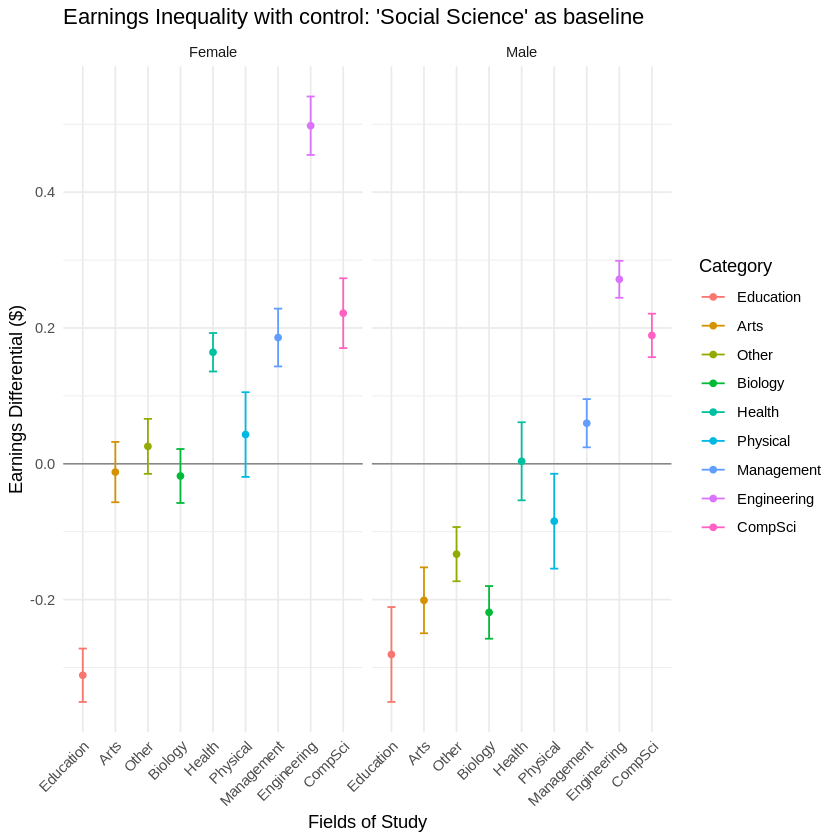

In [23]:
fs <- summary(F3)
ms <- summary(M3)


femalecof <- F3$coefficients[2:10]
femalese <- fs$coefficients[2:10,"Std. Error"]

malecof <- M3$coefficients[2:10]
malese <- ms$coefficients[2:10,"Std. Error"]

baselinefm <- 0

f <- data.frame(Category = names(femalecof), Value = femalecof, SE = femalese, Sex = "Female")
m <- data.frame(Category = names(malecof), Value = malecof, SE = malese, Sex = "Male")

fm <- rbind(f,m)

fm$Category <- factor(fm$Category, levels=c("Education", "Arts", "Other", "Biology","Health", "Physical", "Management","Engineering", "CompSci" ))
t_shift0 <- scales::trans_new("shift",
                             transform = function(x) {x-baselinefm},
                             inverse = function(x) {x+baselinefm})


dodge <- position_dodge(width=0.9)
limits <- aes(ymax=Value+SE,ymin=Value-SE)

ggplot(fm, aes(x=Category,y=Value,group=Sex, col=Category, fill=Category)) + 
  facet_wrap(~Sex) +
  geom_hline(yintercept=0, lwd=0.4, colour="grey50") +
  geom_errorbar(limits, position=dodge, width=0.25) +
  geom_point(position=dodge)+
  labs(title = "Earnings Inequality with control: 'Social Science' as baseline", x = "Fields of Study", y = "Earnings Differential ($)") +
  theme_minimal()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

There are evident gender earnings differentials across fields of study. For men, obtaining a degree in fields other than engineering and computer science can result in either a negligible boost or a substantial penalty on earnings compared to their male counterparts. Women experience significant benefits from obtaining a degree in engineering, and this is the only predominantly male field with hardly a gender pay differential after controlling for individual demographics. 

While we appreciate the positive outcome for women with a degree in engineering, it is essential to investigate further why women with a degree in predominately female fields like education (and health) face such a significant gender pay penalty. The previous study by Morgan (2008) based on 1993 NSCG data shows that women with degrees in these fields have a slight earnings advantage over men, and this result may fail to account for factors like glass ceilings in women’s career paths due to its focus on the early-career stage. Results in other studies may not agree with Morgan (2008). Wilson et al. (2017) compare the gender pay gap for nurses and teachers and reveal women’s disadvantage in earnings in these fields, even though the authors claim that the pay gap is smaller for teachers than for nurses. The current study focuses on the association between fields of study and earnings and thus did not control for occupational characteristics. It would be valuable to explore the reason behind the gender earnings inequality for college graduates in these predominately female fields. For instance, whether women with a degree in education tend to be assigned roles with lower earnings than men of similar qualifications or if wage discrimination within the same role contributes more significantly to the gender pay gap of education degree holders.

This study has provided a comprehensive overview of the correlation between fields of study and earnings inequality, emphasizing its interaction with gender. Existing research on fields of study and earnings inequality is relatively limited in contrast to the substantial studies on education and earnings. Hopefully, these findings can inspire future investigations into this topic, and provide insights on developing targeted policies to foster gender equity in different academic and professional domains.

## Reference

Autor, David H. 2014. “Skills, Education, and the Rise of Earnings Inequality among the ‘Other 99 Percent.’” Science 344 (6186): 843–51. https://doi.org/10.1126/science.1251868.

Autor, David H., Claudia Goldin, and Lawrence F. Katz. 2020. “Extending the Race between Education and Technology.” AEA Papers and Proceedings 110 (May): 347–51. https://doi.org/10.1257/pandp.20201061.

Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistic Tables. R package version 5.2.3. https://CRAN.R-project.org/package=stargazer

Kim, ChangHwan, Christopher R. Tamborini, and Arthur Sakamoto. 2015. “Field of Study in College and Lifetime Earnings in the United States.” Sociology of Education 88 (4): 320–39. https://doi.org/10.1177/0038040715602132.

Morgan, Laurie. 2008. “Major Matters: A Comparison of the Within-Major Gender Pay Gap across College Majors for Early-Career Graduates.” Industrial Relations 47 (4): 625–50. https://doi.org/10.1111/j.1468-232x.2008.00538.x.

National Center for Science and Engineering Statistics (NCSES). 2020. National Survey of College Graduates: 2019. NSF 23-306. Alexandria, VA: National Science Foundation. Available at https://ncses.nsf.gov/pubs/nsf23306/.

Wilson, Barbara L., Matthew J. Butler, Richard Butler, and William G. Johnson. 2017. “Nursing Gender Pay Differentials in the New Millennium.” Journal of Nursing Scholarship 50 (1): 102–8. https://doi.org/10.1111/jnu.12356.

Zhao, John. 2017. “Is Field of Study a Factor in the Earnings of Young Bachelor’s Degree Holders? Census of Population, 2016. Census in Brief.” November 29, 2017. https://eric.ed.gov/?id=ED585326.